In [3]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [17]:
def train(epsilon, layers, learning_rate, buffer_size, batch_size, update_target_freq):

    NUM_RUNS = 10
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(NUM_RUNS):
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DQN(layers)
        target_net = DQN(layers)
        update_target(target_net, policy_net)
        target_net.eval()
        EPS_START = epsilon
        EPS_END = 0.05
        EPS_DECAY = 50
        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(buffer_size)

        steps_done = 0

        episode_durations = []

        for i_episode in range(300):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", 300)

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY), policy_net, state)
                
                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    for param in policy_net.parameters():
                        param.grad.data.clamp_(-1, 1)
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            steps_done += 1
            if i_episode % update_target_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

[]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

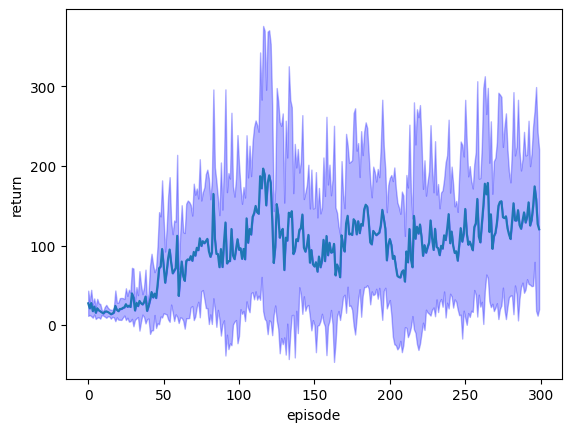

In [19]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
# hyperparameters
# train(epsilon, layers, learning_rate, gamma, buffer_size, batch_size, update_target_freq)
epsilon_range = [0.9]
# [4,256,2] has been tested
layers_range = [[4, 64, 64, 2]]
learning_rate_range = [0.001, 0.0001]
# gamma_range = [0.9, 0.95, 0.99, 0.995, 0.999]
buffer_size_range = [10000]
batch_size_range = [256]
update_target_freq_range = [5, 10, 20]

def hyperparameter_tuning(epsilon_range, layers_range, learning_rate_range, buffer_size_range, batch_size_range, update_target_freq_range):
    results = []
    for epsilon in epsilon_range:
        for layers in layers_range:
            for learning_rate in learning_rate_range:

                for buffer_size in buffer_size_range:
                    for batch_size in batch_size_range:
                        for update_target_freq in update_target_freq_range:
                            
                            res = torch.tensor(train(epsilon, layers, learning_rate, buffer_size, batch_size, update_target_freq))
                            means = res.float().mean(0)
                            stds = res.float().std(0)
                            plt.clf()
                            plt.figure()
                            plt.plot(torch.arange(300), means)
                            plt.ylabel("return")
                            plt.xlabel("episode")
                            plt.fill_between(torch.arange(300), means, means + stds, alpha=0.3, color='b')
                            plt.fill_between(torch.arange(300), means, means - stds, alpha=0.3, color='b')
                            #save the graph
                            plt.savefig("{}_{}_{}_{}_{}_{}.png".format(epsilon, layers, learning_rate, buffer_size, batch_size, update_target_freq))

    return results

# generate the graph for the hyperparameter tuning
# def plot_hyperparameter_tuning(results):
#     for result in results:
#         res = torch.tensor(result[0])
#         means = res.float().mean(0)
#         stds = res.float().std(0)
#         plt.plot(torch.arange(300), means)
#         plt.ylabel("return")
#         plt.xlabel("episode")
#         plt.fill_between(torch.arange(300), means, means + stds, alpha=0.3, color='b')
#         plt.fill_between(torch.arange(300), means, means - stds, alpha=0.3, color='b')
#         #save the graph
#         plt.savefig("{}_{}_{}_{}_{}_{}_{}.png".format(result[1], result[2], result[3], result[4], result[5], result[6], result[7]))

hyperparameter_tuning(epsilon_range, layers_range, learning_rate_range, buffer_size_range, batch_size_range, update_target_freq_range)

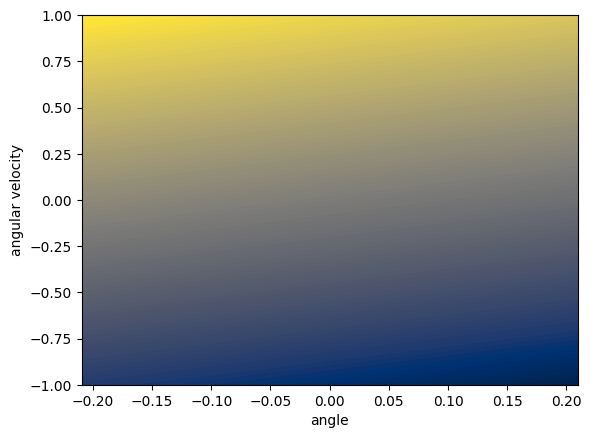

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()